# Figure 8



Load librairies

In [9]:
import pandas as pd                     # Data
import numpy as np                      # Data
import matplotlib.pyplot as plt         # Plot
import matplotlib.patches as mpatches   # Plot

Use Latex Font

In [10]:
plt.rcParams.update({"text.usetex": True,
                     "font.family": "serif",
                     "font.serif": ["Computer Modern"],
                     "font.size": 11,
                     "axes.labelsize": 11,
                     "legend.fontsize": 11,
                     "xtick.labelsize": 9,
                     "ytick.labelsize": 9})  

# Data & Methods

Read CF data

In [11]:
df_combine = pd.read_csv('../Data/cf_combine_1979-2023.csv',
                         index_col = 0,
                         parse_dates = True)

In [12]:
df_combine_avg = df_combine.rolling('D', min_periods = 24, center = True).mean()

Function to identify a RES drought.
 - Select only the values below the selected threshold
 - Group consecutive True/False values and count consecutive hours below threshold
 - Find the end of each drought event
 - Adjust the index to point to the start time of each drought event

In [13]:
def identify_drought(time_series: pd.Series, threshold: float):
    events_thresh = time_series < threshold
    raw_events = events_thresh.groupby(events_thresh.ne(events_thresh.shift()).cumsum()).cumsum()
    identified_events = raw_events[(raw_events.shift(1) < raw_events) & (raw_events.shift(-1) < raw_events)]
    identified_events.index = pd.Index([date - pd.Timedelta(identified_events.loc[date] - 1, unit = 'h') for date in identified_events.index])
    return identified_events

Repeat the function *identify_droughts* for all time series from the *df_combine_avg* data frame.

The events for one series are stored in a pandas Series and those series are stored in a dictonary *droughts_dict*.

In [14]:
droughts_dict = {}

for column in df_combine_avg:
    raw_droughts = identify_drought(df_combine_avg[column], 0.1)
    droughts = raw_droughts[raw_droughts > 24]
    droughts_df = pd.DataFrame(droughts)
    droughts_df = droughts_df.set_axis(['Duration'], axis=1)
    droughts_dict[column] = droughts_df

# Plot

Parameters

In [ ]:
label_name = ['ATL', 'C3S GRD', 'C3S NAT']
title_name = ['a) Wind Only ', 'b) PV Only', 'c) 91\% Wind / 9\% PV', 'd) 57\% Wind / 43\% PV']
color_models = ['#B03024', "#348ABD", '#988ED5']

duration_ranges_days = [0, 1, 2, 3, 4, 5, 6, 7, np.inf]
duration_ranges_hours = [dur * 24 for dur in duration_ranges_days]
xlabel = ['1-2','2-3','3-4','4-5','5-6','6-7', '7-8','8+', '']
bar_width = 0.25

categories = {'wind':          ['ONW_ATL', 'ONW_C3S_GRD', 'ONW_C3S_NAT'],
              'pv':          ['SPV_ATL', 'SPV_C3S_GRD', 'SPV_C3S_NAT'],
              'combine_2023': ['Combine_ATL_2023', 'Combine_C3S_GRD_2030', 'Combine_C3S_NAT_2023'],
              'combine_2030': ['Combine_ATL_2030', 'Combine_C3S_GRD_2030', 'Combine_C3S_NAT_2030']}

cm = 1/2.54

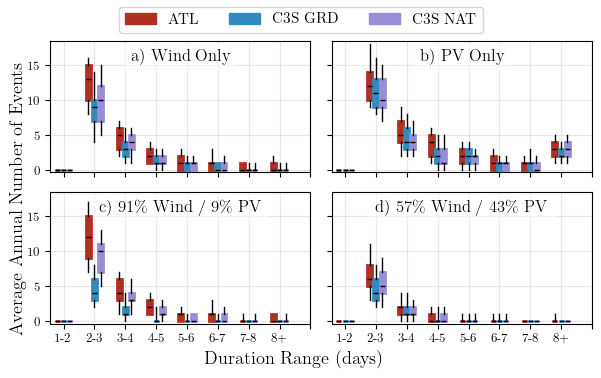

In [16]:
fig, axs = plt.subplots(2, 2, 
                        figsize=(16*cm, 10*cm), 
                        sharex = True, 
                        sharey = True)
axs = axs.flatten()

for idx, (category, datasets_in_category) in enumerate(categories.items()):
    ax = axs[idx]
    positions = np.arange(1, len(duration_ranges_days))

    # Loop over datasets in category
    for i, name in enumerate(datasets_in_category):
        df = droughts_dict[name]
        # Calculate annual number of events for each duration range
        df['DurationRange'] = pd.cut(df['Duration'], bins=duration_ranges_hours)
        df['Year'] = df.index.year
        annual_counts = df.groupby(['Year', 'DurationRange'], observed = True).size().unstack(fill_value = 0)
        full_duration_ranges = pd.IntervalIndex.from_breaks(duration_ranges_hours, closed = 'right')
        annual_counts = annual_counts.reindex(columns=full_duration_ranges, fill_value = 0)
        boxplot_data = [annual_counts[duration].values for duration in full_duration_ranges]

        # Plot boxplot
        boxprop = dict(facecolor=color_models[i], color = color_models[i], linewidth = 2)
        medianprop = dict(color = 'black', linewidth = 1)
        flierprop = dict(markeredgecolor = color_models[i], marker = 'o', ms = 1)
        bplot = ax.boxplot(boxplot_data, positions = positions + i * 0.2 - 0.2,
                           widths = 0.16,
                           patch_artist = True,    
                           boxprops = boxprop,
                           medianprops = medianprop,
                           whis = (5,95),
                           showfliers = False, flierprops = flierprop,
                           manage_ticks = False,
                           notch = False,
                           capwidths = 0,
                           zorder = 2)

    # Axis properties
    ax.margins(0.02)

    ax.set_xticks(np.arange(1, len(duration_ranges_days)+1))
    ax.set_xticklabels(xlabel)

    ax.set_title(title_name[idx], 
                 x = 0.5, y = 1,
                 pad = -14,
                 fontsize = 12, 
                 bbox = dict(facecolor = 'white', alpha = 0.5, edgecolor = 'white'))
    ax.grid(True, alpha=0.3, zorder = 0)

# Legend 
handles = [mpatches.Patch(color=color_models[i], label=label_name[i]) for i in range(len(color_models))]
fig.legend(handles = handles, loc = 'upper center', alignment = 'center', ncols = 3)

fig.supxlabel('Duration Range (days)', y = 0.07)
fig.supylabel('Average Annual Number of Events', x = 0.05)

fig.tight_layout()
fig.subplots_adjust(top = 0.9)
fig.savefig('8_analysis_number_events.pdf', bbox_inches = 'tight')